In [1]:
#ARIMA model for time series analysis
#data retrieval using the yahoo web api, time series transformation, manual and automatic stationarity checks, benchmarking the model versus a naive benchmark, multiple days prediction and multiple symbol prediction mean error checks
#Python code in this project can be used to create a reusable module for predicting any combination of symbols with given date ranges
#statsmodels, a very powerful statistics library offering many statistics functions http://statsmodels.sourceforge.net/devel/index.html#table-of-contents 
#In econometrics and time series analysis the ARIMA model, an acronym for AutoRegressive Integrated Moving Average, is a model that allows us to better understand the time series data and also predict points in the future.
#The model is represented as ARIMA(p, d, q) when p, d, q are non negative integers and they represent the number of passes on each individual process of the model.
#p: corresponds to the “AR” part of the model. An AR(1) is called a first-order auto-regressive model for Y and it defines simple regression with an independent variable being a lagged value of Y(ex Y+1).
#d: corresponds to the “I” part of the model. An I(1) is called a first-order integrated model and it defines the number of the differentiations of the time series in order to make them stationary. 
#stationary series as the series whose mean, variance and autocorrelation are constant over time. Stationary series are easier to predict and stationarity can be approximated by differentiating the data points.
#q: corresponds to the “MA” part of the model. An MA(1) is called a first-order moving average model and it defined the lagged forecast errors of the prediction equation.
#STATIONARITY-----
#We can test a time series for stationarity using the “Augmented Dickey - Fuller” test. This is a test which executes a null hypothesis testing that there is a unit-root with the alternative hypothesis that there is no unit root. A unit root is a random trend in time series and it adds a negative effect on any attempt of prediction. If the p-value of the ad-fuller test is above a critical limit then we cannot reject the null hypothesis and the presence of a unit root. 
#Statsmodels offers a function to perform the ad-fuller test on a time series which will be used in this experiment.
#DURBIN WATSON TEST-----
#The Durbin-Watsos test is a test statistic which reports the presence of autocorrelation in the time series. As autocorrelation we define the error of a period, transferred to another period. 
#For example the underestimation of some profit for period A causes an underestimation of a profit for period B. This test can returns a value between 0 and 4 with 2 being no autocorrelation and the rest of the values defining the presence of positive autocorrelation (0<2) and negative autocorrelation (2<4).
#Note the rcParams dictionary. This is a way to customize how the matplotlib plots will be rendered.
#Needed modules import-----
%matplotlib inline
import os.path
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [2]:
#Declaring the data space-----
#This is the data we will use to train and test the model. 
#Note that the given date range is not going to work for all stock symbols. The user needs to be aware of the date a specific symbol started to trade otherwise the model will throw errors about missing data.
symbol = 'MSFT'
source = 'yahoo'
start_date = '1986-03-13'
end_date = '2018-03-12'
predict_days = 2
filename = '{}_{}_to_{}.csv'.format(symbol, start_date, end_date)

In [3]:
#Retrieving the data-----
#To retrieve the data I am using the pandas datareader. Remember the “source” variable from the input declaration step? This is the actual service from where the data will be fetched. On the first run the data are fethced from the remote service and they are stored on a given filename using the csv file format. 
#If you re-run this step the data will be loaded from the saved file. To achieve a naming consistency the filename consists of the symbol name and the date range as declared on the input declaration step.
start = datetime.datetime.strptime(start_date, "%Y-%m-%d")
end = datetime.datetime.strptime(end_date, "%Y-%m-%d")

if os.path.isfile(filename):
    data = pd.read_csv(filename, parse_dates=True, index_col=0)
else:
    data = web.DataReader(symbol, source, start, end)
    data.to_csv(filename)

data.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-03-06,94.339996,94.489998,92.940002,93.320000,93.320000,22175800
2018-03-07,93.160004,93.940002,92.430000,93.860001,93.860001,26716100
2018-03-08,94.269997,95.099998,93.769997,94.430000,94.430000,25887800
2018-03-09,95.290001,96.540001,95.000000,96.540001,96.540001,36937300
2018-03-12,96.500000,97.209999,96.040001,96.769997,96.769997,26073700


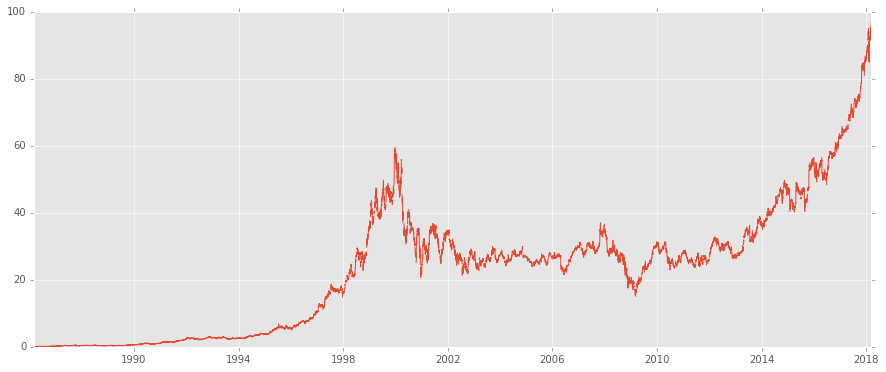

2018-03-06    93.320000
2018-03-07    93.860001
2018-03-08    94.430000
2018-03-09    96.540001
2018-03-10    96.540001
Freq: D, Name: Close, dtype: float64

In [4]:
#Transforming Data-----
#The data from the api do not have available values for the dates the market is closed. This will cause errors on the processing of the data. The ffill method will be used to add those missing data with the value of the previous available date.
#I will compile the train and test data. This will be two sliced datasets out of the original time series. During this process I am also filtering out the columns I don’t need keeping just the Close price of the stock, which will be the values up the model will be build.
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')
original_data = data.fillna(method='ffill')

ran = pd.date_range(start_date, end_date, freq = 'D')
original_data = pd.Series(original_data['Close'], index = ran)

plt.plot(original_data)
plt.show()

original_data = original_data.fillna(method='ffill')

split = len(original_data) - predict_days
train_data, prediction_data = original_data[0:split], original_data[split:]

train_data.tail(5)

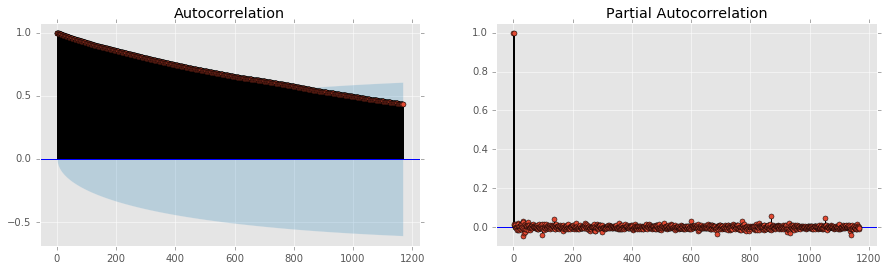

In [5]:
#Stationarity-----
#For the model to be build we need to check the series for stationarity. The code below renders the autocorrelation and partial autocorrelation charts.
#The autocorrelation plot indicates that the time series are not stationary because the values are not reduced at a significant pace. The partial autocorrelation graph above indicates that the value on lag 1 is the only one which is significantly different from 0, so a model AR(1) should be enough.

# rendering such a large time series is compute intensive so I'm breaking it up
didive_large_series_by = 10
fig, axes = plt.subplots(1, 2, figsize=(15,4))
fig = plot_acf(train_data,
               lags = abs(train_data.shape[0]/didive_large_series_by),
               ax=axes[0])
fig = plot_pacf(train_data,
                lags = abs(train_data.shape[0]/didive_large_series_by),
                ax=axes[1])

In [6]:
symbol_diff = train_data - train_data.shift()
symbol_diff = symbol_diff.dropna()
symbol_diff.head(4)

1986-03-14    0.003472
1986-03-15    0.000000
1986-03-16    0.000000
1986-03-17    0.001737
Freq: D, Name: Close, dtype: float64

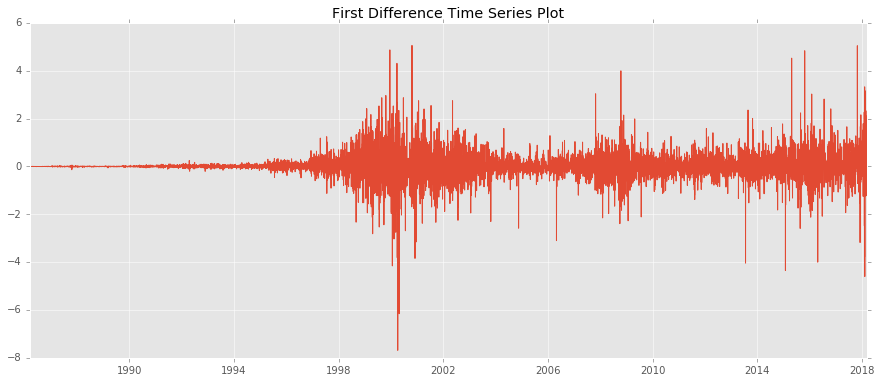

In [7]:
plt.plot(symbol_diff)
plt.title('First Difference Time Series Plot')
plt.show()
#These are the manual steps that can be followed in order to check a signal for stationarity and transform it to be usable for the ARMA models. Since this process is quite manual and there needs to be way to let the program decide whether a time series is stationary or not I am going to use the Ad-fuller test on the next step.

In [8]:
#Ad-fuller test-----
#The process above showed how you can check for stationarity and manually transform the time series. With the ad-fuller test we have a process to check for stationarity which, computetionally, is more convenient.

from collections import namedtuple

ADF = namedtuple('ADF', 'adf pvalue usedlag nobs critical icbest')
stationarity_results = ADF(*smt.adfuller(train_data))._asdict()
significance_level = 0.01

if (stationarity_results['pvalue'] > significance_level):
    message = 'For p-value={:0.4f}, the time series are probably non-stationary'
    print(message.format(stationarity_results['pvalue']))
else:
    message = 'For p-value={:0.4f}, the time series are probably stationary'
    print(message.format(stationarity_results['pvalue']))

print(stationarity_results['critical'])

For p-value=0.9987, the time series are probably non-stationary
{'5%': -2.8617881469447801, '1%': -3.4309114852405713, '10%': -2.5669020835382073}


In [9]:
#Building the model-----
#I will pick an ARIMA(1,1,1) because of non-stationary time series. I’ve noticed that you cannot use any kind of combination on ARIMA(p, d, q). For example the (1,2,1) fails to converge while the (3,2,1) works better and has smaller error rates.
#An explanation of ARIMA(1,1,1) could be the following. We need a model which will try to explain data points with their mean, variance and autocorrelation not being constant, by fixing them with differenciation and exponential smoothing. Practically the AR(1) fixes the positive autocorrelation while and MA(1) fixes the negative autocorrelation. 
#Autocorrelation appears a lot in this context. There are many available explanations on what autocorrelation is. Practically when you analyze time series you don’t want the attribute of a specifit data point to affect the attributes of another data point in the future.
#For example the fact that this months sales are low, should not affect the sales of the next month. You don’t want your data points to be influenced by their own older values.
#p and q also affect the coefficients of the output. The Nth order creates N coefficients.

order = (1, 0, 1) # if the series are stationary, there is no need for an integrated order
if stationarity_results['pvalue'] > 0.01:
    order = (1, 1, 1)

mod = ARIMA(train_data, order = order, freq = 'D')

results = mod.fit()
print(results.summary())
print('DW test is {}'.format(sm.stats.durbin_watson(results.resid.values)))

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                11685
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7189.220
Method:                       css-mle   S.D. of innovations              0.448
Date:                Wed, 14 Mar 2018   AIC                          14386.439
Time:                        17:07:39   BIC                          14415.904
Sample:                    03-14-1986   HQIC                         14396.336
                         - 03-10-2018                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0083      0.004      2.061      0.039       0.000       0.016
ar.L1.D.Close    -0.1913      0.134     -1.426      0.154      -0.454       0.072
ma.L1.D.Close     0.1520      0.135     

In [10]:
#The first thing we need to mention on the summary above is that the true parameters(coef) exist in the 95% confidence interval. The durbin watson test is close to 2 which indicates the lack of autocorrelation.

prediction = results.predict(prediction_data.index[0],
                             prediction_data.index[-1],
                             typ='levels')
prediction.tail(predict_days)

2018-03-11    96.560691
2018-03-12    96.566567
Freq: D, dtype: float64

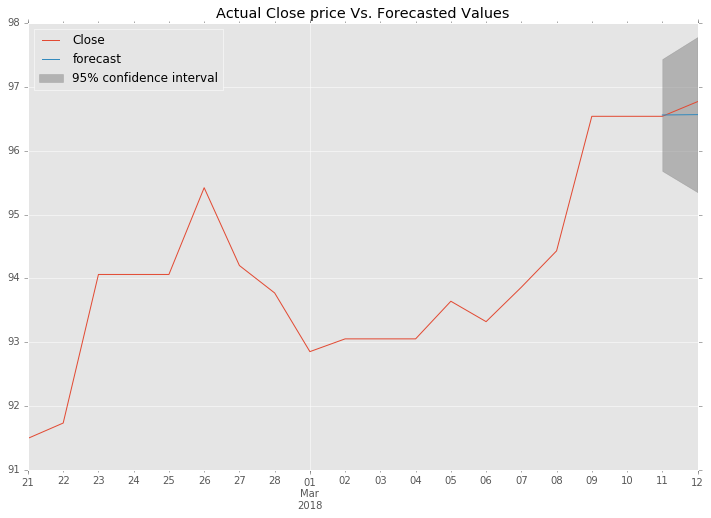

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.title("Actual Close price Vs. Forecasted Values")
ax = original_data.ix[len(original_data)-predict_days*10:].plot(ax=ax)
fig = results.plot_predict(prediction_data.index[0],
                           prediction_data.index[-1],
                           dynamic=True,
                           ax=ax,
                           plot_insample=False)
legend = ax.legend(loc='upper left')
#The graph above shows the predicted values as well and a confidence interval indicating that we can be 95% sure that the price will be between 64.5 and 67. 
#This graph and this confidence interval is rendered for the MSFT symbol using the date range from 2008-01-04 to 2017-04-04 as train data and predicting the dates 2017-04-05 and 2017-04-06.


In [12]:
#On time series the perfomance of the model is quantified by the mean forecast error 
mean_forecast_error = original_data.ix[-predict_days:].sub(prediction).mean()
print('Mean forecast error is {:.2%}'.format(abs(mean_forecast_error)))

Mean forecast error is 9.14%


In [13]:
#Benchmarking-----
#I’m going to check the performance of my model towards a naive prediction. Naive prediction is simply the last day’s value as a forecast for the next day. In python you can simulate this by shifting the prices of the original data by one and compare them with the predicted values as bellow.
naive_prediction = original_data.tail(predict_days+1).shift(1).tail(predict_days)
percentage_change = abs((prediction/naive_prediction-1) *100)
df = pd.concat([naive_prediction, prediction, percentage_change], axis=1)
df.columns = ['Original', 'Predicted', '% Prediction Diff']
df

,Original,Predicted,% Prediction Diff
2018-03-11,96.540001,96.560691,0.021432
2018-03-12,96.540001,96.566567,0.027518


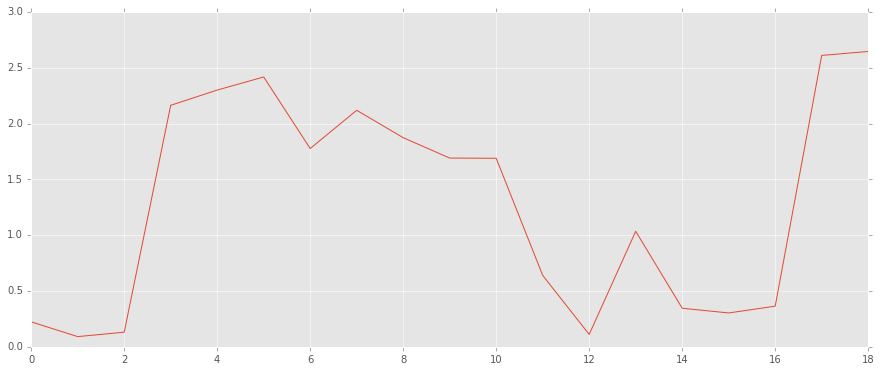

In [14]:
#Compine information-----
#Lets try to check the mean errors for a range of prediction days. To do this I use the model I’ve created above and with every iteration I will be calculating again the train and the test data based on the number of the given prediction days.

mean_errors = []
for number_of_days in range(1, 20):
    split = len(original_data) - number_of_days
    train_data, prediction_data = original_data[0:split], original_data[split:]
    mod = ARIMA(train_data, order = (1, 1, 1), freq = 'D')
    results = mod.fit(disp=0)
    prediction = results.predict(prediction_data.index[0],
                                 prediction_data.index[-1],
                                 typ='levels')
    original_data_sample = original_data.ix[-number_of_days:]
    mean_errors.append(abs(original_data_sample.sub(prediction).mean()))

plt.plot(mean_errors)
plt.show()
#As we notice there is a good prediction rate up to the first 6 days with a mean error of around 20%. After that the error explodes and it even exceeds the 100% mark on the 15 days.

In [ ]:
#I have tested the predictive capabilities of the ARIMA group of models. I have also investigated the performance of my models towards multiple input days and the performance on multiple input symbols for the same date range.
#ARIMA proved to be quite performant in most occasions. The mean forecast error for predicting two days for the microsoft stock price proved to be just 0.26% different than the naive benchmark for the same days.
#There are some cases where the model did not perform well.An econometric model can fail because of internal unknown processes, unexpected failures which affect the train data and changes on external distributions such as the market, economy or governmental policy.
#we would like to expand this time series analysis and use multiple models for the same prediction period and pick the one which works the best for the specific underlying target. In modern computing systems this process can be spanned across multiple machines and predict multiple combinations of symbols and date ranges in parallel.
#References------
#http://www.agounaris.eu/posts/2017/05/01/stock-symbol-time-series-analysis-and-prediction-with-arima-model.html
#Ayodele A. Adebiyi, Aderemi O. Adewumi, Charles K. Ayo, “Stock Price Prediction Using the ARIMA Model”, UKSim-AMSS 16th International Conference on Computer Modelling and Simulation 2014
#David F. Hendry, Grayham E. Mizon, “Unpredictability in Economic Analysis, Econometric Modeling and Forecasting” University of Oxford 2013
#Michael Wagner, “Forecasting Daily Demand in Cash Supply Chains”, American Journal of Economics and Business Administration 2 (4): 377-383, 2010 ISSN 1945-5488, 2010
#Javier Contreras, Rosario Espínola, Francisco J. Nogales, Antonio J. Conejo, “ARIMA Models to Predict Next-Day Electricity Prices”, IEEE Transactions on power systems, vol 18, no 3, Aug. 2003